In [1]:
import torch
from PIL import Image
from matplotlib import pyplot as plt
import argparse
import numpy as np
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
from zoedepth.utils.geometry import depth_to_points
import open3d as o3d
from zoedepth.utils.misc import colorize
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def get_intrinsics(H,W):
    """
    Intrinsics for a pinhole camera model.
    Assume fov of 55 degrees and central principal point.
    """
    f = 0.5 * W / np.tan(0.5 * 55 * np.pi / 180.0)
    cx = 0.5 * W
    cy = 0.5 * H
    return np.array([[f, 0, cx],
                     [0, f, cy],
                     [0, 0, 1]])

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
model_name = "zoedepth"

conf = get_config(model_name, "infer")
model = build_model(conf).to(DEVICE)
#model.eval()

Using device: cuda
img_size [384, 512]


Using cache found in /home/seba2411/.cache/torch/hub/intel-isl_MiDaS_master
/home/seba2411/miniconda3/envs/zoe/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


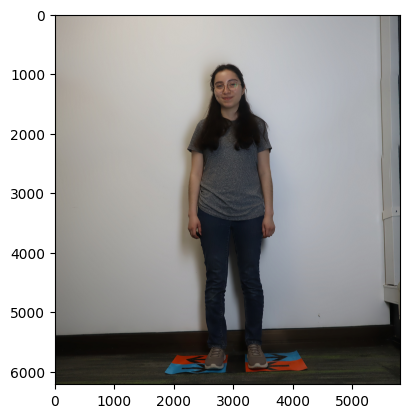

In [4]:
image_path = "./input/resultado_opencv/138/138_stitch_affine.jpg"
img = Image.open(image_path).convert("RGB")
img_np = np.array(img)
plt.imshow(img)

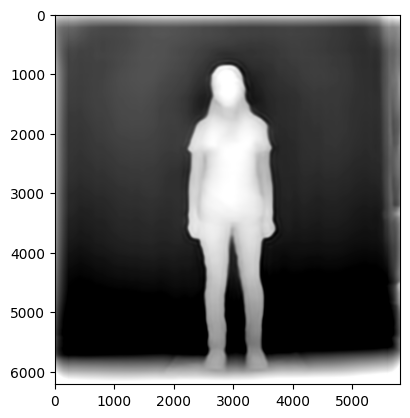

In [5]:
with torch.no_grad():
        depth = model.infer_pil(img)
#print(depth)
colored = Image.fromarray(colorize(depth))
plt.imshow(colored)

In [6]:
R = None
t = None
depth_n = depth[None]

K = get_intrinsics(depth_n.shape[1], depth_n.shape[2])
Kinv = np.linalg.inv(K)
if R is None:
    R = np.eye(3)
if t is None:
    t = np.zeros(3)

In [7]:
M = np.eye(3)
M[0, 0] = -1.0
M[1, 1] = -1.0

height, width = depth_n.shape[1:3]

x = np.arange(width)
y = np.arange(height)
coord = np.stack(np.meshgrid(x, y), -1)
coord = np.concatenate((coord, np.ones_like(coord)[:, :, [0]]), -1)  # z=1
coord = coord.astype(np.float32)
# coord = torch.as_tensor(coord, dtype=torch.float32, device=device)
coord = coord[None]  # bs, h, w, 3

In [8]:
D = depth_n[:, :, :, None, None]
# print(D.shape, Kinv[None, None, None, ...].shape, coord[:, :, :, :, None].shape )
pts3D_1 = D * Kinv[None, None, None, ...] @ coord[:, :, :, :, None]
# pts3D_1 live in your coordinate system. Convert them to Py3D's
pts3D_1 = M[None, None, None, ...] @ pts3D_1
# from reference to targe tviewpoint
pts3D_2 = R[None, None, None, ...] @ pts3D_1 + t[None, None, None, :, None]
# pts3D_2 = pts3D_1
# depth_2 = pts3D_2[:, :, :, 2, :]  # b,1,h,w
#print( pts3D_2[:, :, :, :3, 0][0])

points = pts3D_2.reshape(-1, 3)

In [9]:
pixel_coords = [(2000, 3000)]
coordinates_3d = []

for x, y in pixel_coords:
    idx = y * img_np.shape[1] + x
    point_3d = points[idx]
    coordinates_3d.append(point_3d)

print(coordinates_3d)

[array([0.37442553, 0.04387961, 2.30967879])]
